## Imports and Data Loading

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
import scipy
from numpy.fft import fft
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from dask import dataframe as dd 
np.random.seed(8055)

In [14]:
# load data
hr = pd.read_csv('data/alpaca_hr.csv')
resp = pd.read_csv('data/alpaca_resp.csv')
sao2 = pd.read_csv('data/alpaca_sao2.csv')

hr['offset'] = hr['offset']
resp['offset'] = resp['offset']
sao2['offset'] = sao2['offset']

gcs = pd.read_csv('data/patient_motor.csv')
gcs = gcs[gcs['observationoffset'] > -1]
gcs['offset'] = gcs['observationoffset']
gcs['key'] = gcs['Key']
gcs['value'] = gcs['Value']
gcs = gcs.drop(['observationoffset', 'origin', 'Key', 'Value'], axis = 1)
final_gcs_id = gcs.groupby('patientunitstayid')['offset'].transform(max) == gcs['offset']

measurements = pd.DataFrame(columns=['patientunitstayid','key','value', 'offset'])
hr['key'] = 'hr'
resp['key'] = 'resp'
sao2['key'] = 'sao2'
measurements = measurements.merge(hr, how = 'outer').merge(resp, how = 'outer').merge(sao2, how = 'outer').merge(gcs, how = 'outer')

measurements = measurements.dropna()
display(measurements)

,patientunitstayid,offset,value,key
12,143274,61.0,95.0,hr
13,143274,66.0,97.0,hr
14,143274,71.0,97.0,hr
15,143274,76.0,98.0,hr
16,143274,81.0,98.0,hr
...,...,...,...,...
10460727,3352819,697.0,6.0,Motor
10460728,3352819,817.0,6.0,Motor
10460729,3352819,1057.0,6.0,Motor
10460730,3352819,3970.0,6.0,Motor


# Lab Data

In [15]:
# Loading lab data
lab = pd.read_csv('data/lab_data.csv')
lab = lab.loc[lab['labresultoffset'] > -1]
display(lab)
labtypes = list(lab['labname'].drop_duplicates())

,Unnamed: 0,patientunitstayid,diagnosisstring,labid,patientunitstayid.1,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
0,0,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,228078093,976143,1552,1.0,albumin,3.4,3.4,g/dL,g/dL,1583
1,1,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,229470282,976143,1552,3.0,Hct,36.8,36.8,%,%,1595
2,2,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,231416160,976143,1781,4.0,bedside glucose,103.0,103,mg/dL,mg/dL,1781
3,3,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,231286752,976143,1866,4.0,bedside glucose,101.0,101,mg/dL,mg/dL,1866
6,6,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,228078090,976143,1552,1.0,AST (SGOT),9.0,9,Units/L,IU/L,1583
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374619,374619,962326,neurologic|trauma - CNS|intracranial injury|wi...,228977417,962326,3129,1.0,AST (SGOT),58.0,58,Units/L,IU/L,3234
2374620,374620,962326,neurologic|trauma - CNS|intracranial injury|wi...,228165753,962326,1809,1.0,potassium,3.3,3.3,mmol/L,mmol/L,1873
2374621,374621,962326,neurologic|trauma - CNS|intracranial injury|wi...,228977416,962326,3129,1.0,ALT (SGPT),71.0,71,Units/L,IU/L,3234
2374622,374622,962326,neurologic|trauma - CNS|intracranial injury|wi...,228165758,962326,1809,1.0,sodium,148.0,148,mmol/L,mmol/L,1873


In [27]:
labmeasures = measurements.copy()
toAdd = pd.DataFrame(columns=['patientunitstayid','key','value', 'offset'])
toAdd['patientunitstayid'] = lab['patientunitstayid']
toAdd['key'] = lab['labname']
toAdd['value'] = lab['labresult']
toAdd['offset'] = lab['labresultoffset']
labmeasures = labmeasures.merge(toAdd, how = 'outer')   
labmeasures = labmeasures.dropna()
display(labmeasures)

,patientunitstayid,offset,value,key
0,143274,61.0,95.0,hr
1,143274,66.0,97.0,hr
2,143274,71.0,97.0,hr
3,143274,76.0,98.0,hr
4,143274,81.0,98.0,hr
...,...,...,...,...
12322360,962326,3129.0,58.0,AST (SGOT)
12322361,962326,1809.0,3.3,potassium
12322362,962326,3129.0,71.0,ALT (SGPT)
12322363,962326,1809.0,148.0,sodium


# Demographic Data

In [104]:
# Loading demographic data
demographic_all = pd.read_csv('data/patient_demographics_data.csv')
#demographic_all.head()
died = demographic_all.loc[:, ['patientunitstayid', 'unitdischargestatus']]
died['alive'] = died['unitdischargestatus'] == 'Alive'
died = died.drop_duplicates()
#display(died)

In [105]:
#for col in demographic_all.columns:
#    print(col)

# Keeping the following columns (numerical for now):
# to_keep=['gender', 'age', 'ethnicity', 'admissionheight', 'admissionweight']
to_keep=['age', 'admissionheight', 'admissionweight', 'patientunitstayid']
demographic = demographic_all[to_keep]
#demographic.head()
#print(demographic.dtypes)

In [106]:
demographic = demographic.replace('> 89', 90)
#demographic.head()

## Set Parameters

In [21]:
# prediction frequency refers to the frequency with which we want to predict GCS
prediction_freq = 2

# summarization interval refers to the spacing between edges of the bins of our histogram (for summarizing physiology)
summarization_int = 60

## Bin data

In [59]:
'''
# split data into bins based on summarization_int
m = labmeasures.copy()
sd = dd.from_pandas(m, npartitions=8)
sd['offsetBin'] = sd['offset'].map_partitions(pd.cut, np.arange(24*60, step=summarization_int)).astype(int)
measures_grouped = sd.groupby(['patientunitstayid', 'offsetBin', 'key']).agg({'value': ['mean', 'std']}).compute()
print(measures_grouped)
'''

ValueError: cannot convert float NaN to integer

In [60]:
m = labmeasures.copy()
m = m[m['offset'] < 1440]
m['offsetBin'] = (m['offset']/summarization_int).astype(int)
m = m.drop('offset', axis = 1)
measures_grouped = m.groupby(['patientunitstayid', 'offsetBin', 'key']).mean().reset_index()

m2 = measures_grouped.copy()
m2['pat_off'] = m2['patientunitstayid'].astype(str) + '_' + m2['offsetBin'].astype(str)
m2 = m2.pivot(index='pat_off',columns='key', values='value')
display(m2)

key,-bands,-basos,-eos,-lymphs,-monos,-polys,24 h urine protein,ALT (SGPT),AST (SGOT),Acetaminophen,...,total protein,transferrin,triglycerides,troponin - I,troponin - T,uric acid,urinary creatinine,urinary osmolality,urinary sodium,urinary specific gravity
pat_off,,,,,,,,,,,,,,,,,,,,,
1000755_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,73.0,NaN,...,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000755_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000755_14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000755_19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000755_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.58,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999588_21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999588_23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999588_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot Samples

Text(0.5, 1.0, 'Motor GCS')

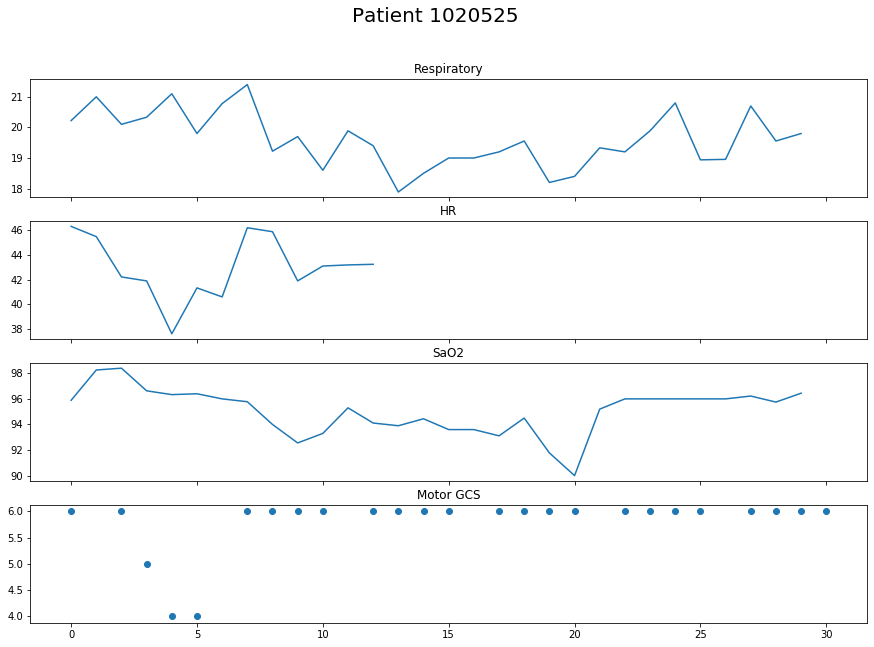

In [127]:
# get one patient's data
ind_slice = np.argwhere(hr_grouped['patientunitstayid'] == 1020525).flatten()
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,10))
f.suptitle("Patient 1020525", size = 20)
ax1.plot(np.arange(resp_grouped[resp_grouped.index.isin(ind_slice)]['value'].shape[0]),
         resp_grouped[resp_grouped.index.isin(ind_slice)]['value'])
ax1.set_title("Respiratory")

ax2.plot(np.arange(hr_grouped[hr_grouped.index.isin(ind_slice)]['value'].shape[0]),
         hr_grouped[hr_grouped.index.isin(ind_slice)]['value'])
ax2.set_title("HR")

ax3.plot(np.arange(sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'].shape[0]),
         sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'])
ax3.set_title("SaO2")

ax4.scatter(gcs_grouped[gcs_grouped.index.isin(ind_slice)]['offset_bin'], gcs_grouped[gcs_grouped.index.isin(ind_slice)]['value'])
ax4.set_title("Motor GCS")

## Prepare Datasets

In [128]:
# interpolate signal
hr_first24 = hr_grouped.copy()
resp_first24 = resp_grouped.copy()
sao2_first24 = sao2_grouped.copy()
gcs_first24 = gcs_grouped.copy()

hr_first24['value'] = hr_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
resp_first24['value'] = resp_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
sao2_first24['value'] = sao2_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
gcs_first24['value'] = gcs_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']

In [129]:
# get first 24 hrs
myInt = 24.0 / summarization_int

hr_first24 = hr_first24.loc[hr_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
resp_first24 = resp_first24.loc[resp_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
sao2_first24 = sao2_first24.loc[sao2_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
gcs_first24 = gcs_first24.loc[gcs_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])

# fill remaining na fields (beginning of patient stay if any) with overall signal mean (maybe median itf?)
hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))

#hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.median())

#display(resp_first24)
#display(sao2_first24)

In [130]:
further_exclusion = hr_first24.loc[hr_first24.isna()['value']]['patientunitstayid'].unique()
further_exclusion = np.hstack([further_exclusion, resp_first24.loc[resp_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, sao2_first24.loc[sao2_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, gcs_first24.loc[gcs_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.unique(further_exclusion)
#print(further_exclusion.shape)

In [131]:
# organize by patient

# first grab all the patient ids

# ISSUE: some patients are not represented, need to think of how to include them, perhaps -1?
keys1, keys2, keys3, keys4 = hr['patientunitstayid'].unique(), resp['patientunitstayid'].unique(), sao2['patientunitstayid'].unique(), final_gcs['patientunitstayid'].unique()
keys = []
for k in keys1:
    if (k in keys2) and (k in keys3) and (k in keys4) and (k not in further_exclusion):
        keys.append(k)

# now stack data based on the same patient order
X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_hr = X_hr.T
X_resp = X_resp.T
X_sao2 = X_sao2.T
X_gcs = X_gcs.T
#print(X_gcs)

# Modeling

In [132]:
# SET PARAMETERS

# number of pca components to extract
num_components = 40

# number of fourier features to extract
num_fourier_components = 40

# choose resampling technique
resampling = 'over'

# select model family
model_family = 'logistic'

In [141]:
id_df = pd.DataFrame(keys, columns =['patientunitstayid'])
# id_df.head()
labtypedata_cts_allids = labtypedata_cts.merge(id_df, how='right', on='patientunitstayid')
labtypedata_cts_allids = labtypedata_cts_allids.fillna(0)
#print(labtypedata_cts_allids.shape)
labtypedata_cts_allids.head()

,patientunitstayid,Hct,Hgb,MCV,RBC,platelets x 1000,WBC x 1000,MCHC,RDW,chloride,sodium,glucose,calcium,bicarbonate,creatinine,BUN,potassium
0,172448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,242714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,242825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,243176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,243493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [134]:
labtypedata_avgs_allids = labtypedata_avgs.merge(id_df, how='right', on='patientunitstayid')
#print(labtypedata_avgs_allids.shape)
for l in labtypedata_avgs_allids.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs_allids[l]
        labtypedata_avgs_allids[l] = col.fillna(lab_avgs_map[l])
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
#labtypedata_avgs_allids.head()

In [135]:
dem_allids = demographic.merge(id_df, how='right', on='patientunitstayid')
dem_allids = dem_allids.drop_duplicates()
#print(dem_allids.shape)
dem_allids = dem_allids.fillna(dem_allids.mean())
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
#dem_allids.head()

death = died.merge(id_df, how = 'right', on = 'patientunitstayid')
deathstatus = death['alive'].values[:, np.newaxis]

In [136]:
labavg_cols = []
for c in labtypedata_avgs_allids.columns:
    if c != 'patientunitstayid':
        labavg_cols.append(c)
X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
        None] for g in keys])[0]

labcts_cols = []
for c in labtypedata_cts_allids.columns:
    if c != 'patientunitstayid':
        labcts_cols.append(c)
X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
        None] for g in keys])[0]

dem_cols = []
for c in dem_allids.columns:
    if c != 'patientunitstayid':
        dem_cols.append(c)
X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

In [137]:
mort = False
scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

X_labdem = np.hstack([X_labavgs, X_labcts, X_dem])
scaler.fit(X_labdem)
X_labdem = scaler.transform(X_labdem)

X_naive = np.hstack([X_phys, X_labdem])
target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
        None] for g in keys])

# split data
if mort:
    trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
else:
    trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

In [138]:
# modify labels
if mort:
    testY_mod = testY.copy()
    testY_mod[testY == False] = 0
    testY_mod[testY == True] = 1

    trainY_mod = trainY.copy()
    trainY_mod[trainY ==False] = 0
    trainY_mod[trainY == True] = 1

else:
    testY_mod = testY.copy()
    testY_mod[testY < 6] = 1
    testY_mod[testY == 6] = 0

    trainY_mod = trainY.copy()
    trainY_mod[trainY < 6] = 1
    trainY_mod[trainY == 6] = 0

# train model
model_family = 'logistic'
if model_family == 'logistic':
    clf = LogisticRegression(max_iter=2000, penalty='elasticnet', l1_ratio=0.5,
                         solver='saga', C=.8)
    
elif model_family == 'random_forest':
    clf = RandomForestClassifier(max_depth=2, n_estimators=10)

print(trainX.shape)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

(2464, 60)
Train Score: 0.8583603896103896


Test Score: 0.8948
AUC: 0.9139
Sensitivity: 0.617
Specificity: 0.9663
Precision: 0.7333
Recall: 0.7801


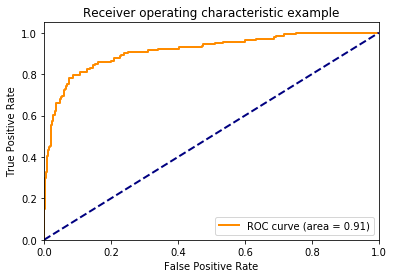

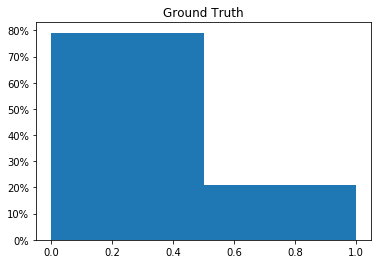

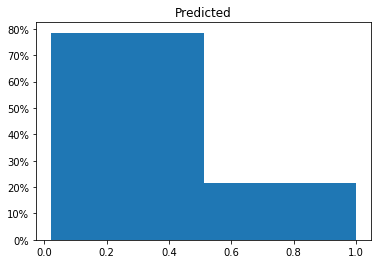

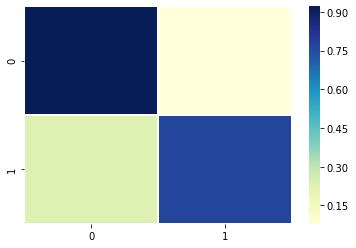

In [139]:
# test model
predY = clf.predict_proba(testX)[:, 1]
print("Test Score:", np.round(clf.score(testX, testY_mod), 4))

# get auc
auc = roc_auc_score(testY_mod, predY)
print("AUC:", np.round(auc, 4))

# plot roc curve
fpr, tpr, roc_thresholds = roc_curve(testY_mod, predY)
precision, recall, thresholds = precision_recall_curve(testY_mod, predY)

# optimize for precision and recall
best_pr_thresh = np.argmax(np.square(precision) + np.square(recall))

# find corresponding threshold index for roc curve (thresholds are reverse order)
roc_thresh = int(roc_thresholds.shape[0] * (1 - best_pr_thresh / thresholds.shape[0]))

#print('roc thresh:', roc_thresholds.shape)
#print('pr thresh:', thresholds.shape)

print("Sensitivity: " + str(np.round(tpr[roc_thresh], 4)))
print("Specificity: " + str(np.round(1 - fpr[roc_thresh], 4)))
print("Precision: " + str(np.round(precision[best_pr_thresh], 4)))
print("Recall: " + str(np.round(recall[best_pr_thresh], 4)))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# class balance
plt.hist(testY_mod, bins=2, weights=np.ones(len(testY_mod)) / len(testY_mod))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Ground Truth")
plt.show()

plt.hist(predY, bins=2, weights=np.ones(len(predY)) / len(predY))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Predicted")
plt.show()

# heatmap
predY = predY > thresholds[bestThreshInd]
confusion = confusion_matrix(predY, testY_mod)
confusion = confusion / np.sum(confusion, axis=1)[:, None]
heatmap = sns.heatmap(confusion, linewidths=.5, cmap="YlGnBu")